In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import binom

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import combinations
from collections import Counter
from tqdm import tqdm

In [2]:
random.seed(42)

In [3]:
def roll_freq_table(rolls):
    """
    Generate a frequency table of rolled dice values for each player.

    This function takes a list of lists, where each inner list represents the dice rolls
    of a single player. It converts these rolls into a frequency table representing
    the count of each dice face from 1 to 6.

    Args:
    rolls (list of list of int): A list where each element is a list of integers representing
                                  the dice rolls of a single player.

    Returns:
    list of list of int: A list of frequency tables for each player, with each table
                         being a list of counts of dice faces [1, 2, 3, 4, 5, 6].
    """
    # Initialize an empty list to hold the frequency tables
    frequency_tables = []

    # Loop through each player's rolls
    for player_rolls in rolls:
        # Use numpy's bincount to count the occurrences of each number in the rolls,
        # starting from index 1 since dice faces are 1-6, not 0-5.
        # The minlength parameter ensures that the count array has a length of 7,
        # so we can safely ignore the 0th index and use indices 1-6 to represent dice faces.
        frequency_table = np.bincount(player_rolls, minlength=7)[1:].tolist()

        # Append the frequency table to the list
        frequency_tables.append(frequency_table)

    # Return the list of frequency tables
    return frequency_tables

def roll_once(n_player, player_dice_count_list):
    """
    Roll dice once for each player and return a frequency table of results.

    This function simulates a single round of dice rolls for each player in the game.
    Each player rolls a number of dice specified by player_dice_count_list and the
    results are converted into a frequency table by roll_freq_table function.

    Args:
    n_player (int): Number of players rolling the dice.
    player_dice_count_list (list of int): A list containing the number of dice each player rolls.

    Returns:
    list: A list of frequency tables, one for each player's roll in the current round.
    """
    # Initialize an empty list to store the rolls of each player
    rolls = []

    # Loop over the number of players
    for player_index in range(n_player):
        # Randomly choose dice rolls for the current player, where range(1, 7) represents
        # the six faces of a dice and k is the number of dice the current player is rolling.
        player_rolls = random.choices(range(1, 7), k=player_dice_count_list[player_index])

        # Sort the rolls for readability (optional) and append to the main rolls list
        rolls.append(sorted(player_rolls))

    # Call the roll_freq_table function to get the frequency table for the current round of rolls
    return roll_freq_table(rolls)


In [4]:
from scipy.stats import binom

def calc_prob(x, bin_size=20):
    """
    Calculate the probability that there is at least the bid quantity on the table.

    This function computes the probability of having at least a certain number of a specific dice face
    showing among all dice rolled, based on the binomial distribution. It can be used to make
    decisions on whether to challenge a claim during a game of Liar's Dice.

    Args:
        x (list): List containing [total_dice, player's_dice, claim_quantity, player's_claim_quantity].
        bin_size (int): The number of bins used to scale the probability (default is 20).

    Returns:
        int: The probability scaled by the bin_size.
    """
    # If the claim quantity is less than or equal to what the player has, return 100%
    if x[2] <= x[3]:
        return 1 * bin_size

    # Otherwise, calculate the probability using the binomial PMF
    else:
        total_dice = x[0]
        claim_quantity = x[2]
        player_quantity = x[3]
        probability = 0

        # Sum the probabilities from the claim quantity minus what the player has to the total number of dice
        for k in range(claim_quantity - player_quantity, total_dice + 1):
            probability += binom.pmf(k, total_dice, 1/6)

        # Return the probability floored to the nearest bin_size
        return int(np.floor(probability * bin_size))


In [5]:
def convert_to_list(claim_str):
    """
    Convert a claim string to a list with the claim value and quantity.

    This function parses a string representing a claim in Liar's Dice, where each
    character's index in the string represents the face value of the dice (1-indexed),
    and the character itself represents the quantity of that face value claimed.

    Args:
        claim_str (str): A string representing the dice claim.

    Returns:
        list: A list containing the claim value and quantity as integers.
    """
    # If the length is 7, then the claim has a quantity of 10 or higher
    if len(claim_str) == 7:
        for index, char in enumerate(claim_str):
            if char != '0':
                claim_value = index + 1
                claim_qty = int(claim_str[index:index+2])
                return [claim_value, claim_qty]
    else:
        # Otherwise, each quantity is a single digit
        for index, char in enumerate(claim_str):
            if char != '0':
                claim_value = index + 1
                claim_qty = int(char)
                return [claim_value, claim_qty]

def agent(total_dice_count, decide_or_claim, agent_roll_table, Q_mat, last_claim):
    """
    Define the agent's decision-making process for doubting or making a claim.

    Depending on the mode, the agent uses a Q-matrix to decide whether to doubt the
    previous claim or to make a new claim. The decision is based on probabilities
    derived from the Q-matrix.

    Args:
        total_dice_count (int): Total number of dice the agent has.
        decide_or_claim (str): A string indicating the agent's mode, either 'decide' to doubt or 'claim' to make a new claim.
        agent_roll_table (list): A list representing the agent's dice roll.
        Q_mat (DataFrame): A pandas DataFrame representing the Q-matrix.
        last_claim (list): A list containing the last claim's value and quantity.

    Returns:
        bool or list: If deciding, returns True or False to doubt. If claiming, returns a list representing the new claim.
    """
    # Extract the value and quantity from the last claim
    claim_value, claim_qty = last_claim

    # Initialize a list to hold the claim in string format
    claim_list = [0] * 6
    claim_list[claim_value-1] = claim_qty  # Set the non-zero value for the claim
    string_result = ''.join(str(num) for num in claim_list)

    # Convert the agent's rolls to a string format
    string_result2 = ''.join(str(num2) for num2 in agent_roll_table)

    # Retrieve the probabilities list from the Q-matrix
    prob_list = Q_mat.loc[str(string_result2), str(string_result)]

    # If deciding to doubt...
    if decide_or_claim == 'decide':
        # Randomly choose to doubt or not based on the probabilities
        return random.choices([True, False], weights=[prob_list[0], 1-prob_list[0]], k=1)[0]

    # If making a new claim...
    elif decide_or_claim == 'claim':
        # Initialize a list to represent the maximum valid claim
        valid_claim_list = [0] * 6
        valid_claim_list[-1] = total_dice_count  # Set the non-zero value to the total dice count
        valid_max_claim = ''.join(str(num) for num in valid_claim_list)

        # Find the indices for the current and maximum valid claims within the Q-matrix
        current_index = Q_mat.columns.get_loc(str(string_result))
        max_index = Q_mat.columns.get_loc(str(valid_max_claim))

        # Create a list of possible new claims based on the Q-matrix
        choices_list = Q_mat.columns[current_index+1:max_index+1].tolist()
        modified_list = prob_list[1:max_index-current_index+1]

        # Normalize the probabilities for the new claims
        total = sum(modified_list)
        normalized_list = [prob / total for prob in modified_list]

        # Randomly choose a new claim based on the normalized probabilities
        chosen_choice = np.random.choice(choices_list, p=normalized_list)
        claim = convert_to_list(chosen_choice)  # Convert the chosen claim back to list format

        return claim

In [6]:
def random_claim(total_dice_count, dice_count, last_claim):
    """
    Generate a random claim based on a strategy (bluff, random, or conservative).

    The function determines a random strategy for making a claim in a game of Liar's Dice.
    It then generates a claim based on that strategy relative to the last claim made.

    Args:
        total_dice_count (int): The total number of dice in play for the agent.
        dice_count (list): A list representing the count of each dice face for the agent.
        last_claim (tuple): A tuple (claim_value, claim_qty) representing the last claim made.

    Returns:
        list: A list [claim_value, claim_qty] representing the new claim.

    Raises:
        NotImplementedError: If neither bluff option is viable.
        ValueError: If no valid claim can be made.
    """
    claim_value, claim_qty = last_claim

    # Determine the strategy for the next claim
    strategy = random.choices(['Bluff', 'Random', 'Conservative'], k=1)[0]

    # Execute the chosen strategy
    if strategy == 'Bluff':
        bluff_options = ['Add Number', 'Add Value']
        random.shuffle(bluff_options)  # Shuffle to randomize the bluff strategy

        for bluff_strat in bluff_options:
            if bluff_strat == 'Add Number' and claim_qty < total_dice_count:
                # Increase the quantity of the claim
                claim_val = random.randint(1, 6)
                claim = [claim_val, claim_qty + 1]
                break
            elif bluff_strat == 'Add Value' and claim_value < 6:
                # Increase the face value of the claim
                claim = [claim_value + 1, claim_qty]
                break
        else:
            # If neither bluff strategy is viable, raise an error
            raise NotImplementedError('It is the max claim')

    elif strategy == 'Conservative':
        # Make a conservative claim based on the most frequent dice face
        max_index = np.argmax(dice_count) + 1
        if claim_qty < total_dice_count:
            claim = [max_index, claim_qty + 1]
        else:
            # If the quantity is already at max, increase the face value
            claim = [random.randint(claim_value + 1, 6), claim_qty]

    elif strategy == 'Random':
        # Make a random claim, potentially increasing number, value, or both
        rand_strat = random.choice(['Add Number', 'Add Value', 'Add Both']) if claim_value < 6 and claim_qty < total_dice_count else 'Add Number' if claim_value == 6 else 'Add Value'

        if rand_strat == 'Add Number' and claim_qty < total_dice_count:
            # Randomly increase the quantity of the claim
            claim_val = random.randint(1, 6)
            qty = random.randint(claim_qty + 1, total_dice_count)
            claim = [claim_val, qty]
        elif rand_strat == 'Add Value' and claim_value < 6:
            # Randomly increase the face value of the claim
            value = random.randint(claim_value + 1, 6)
            claim = [value, claim_qty]
        elif rand_strat == 'Add Both':
            # Randomly increase both the quantity and face value of the claim
            qty = random.randint(claim_qty + 1, total_dice_count)
            val = random.randint(claim_value + 1, 6)
            claim = [val, qty]
        else:
            # If the strategy chosen is not applicable, raise an error
            raise NotImplementedError(f'It is the max claim with {claim_value, claim_qty}, total dice count = {total_dice_count}')

    # Ensure a valid claim was made
    if 'claim' not in locals():
        raise ValueError("No valid claim could be made.")

    return claim

def random_decide(x_list):
    """
    Randomly decide whether to doubt the current claim based on a fixed and probabilistic rule.

    This function decides whether to doubt the current claim in a game of Liar's Dice
    using a mix of fixed and probabilistic decision rules. The decision is influenced
    by the probability of the claim being true.

    Args:
        x_list (list): A list containing [total_dice, player's_dice, claim_qty, player's_claim_qty].

    Returns:
        bool: The decision to doubt (True) or not doubt (False).
    """
    # If the claim is the maximum possible, decide to doubt
    if x_list[0] == x_list[2]: #max qty claim
        return True

    prob_cat = calc_prob(x_list)

    if random.random() < 0.7:
        return random.choices([True, False], weights=[0.5, 0.5], k=1)[0]
    return random.choices([True, False], weights=[1-0.05*prob_cat, 0.05*prob_cat], k=1)[0]


In [7]:
def outcome(claim, true_state):
    """
    Determine the outcome of a claim by comparing it to the true state of the dice.

    This function checks if the claim made about a dice roll is true by comparing the
    quantity of the claimed dice face against the actual quantity in the true state.
    It is used to resolve challenges in the game of Liar's Dice.

    Args:
        claim (list): A list containing the claimed value and the claimed quantity, [claim_value, claim_qty].
        true_state (list): A list representing the actual count of each die face.

    Returns:
        bool: The truthfulness of the claim; True if the claim is equal to or less than the true state, False otherwise.
    """
    # Calculate the index of the claimed value in the true state list
    claim_value_idx = claim[0] - 1
    claim_qty = claim[1]

    # Retrieve the true quantity of the claimed face value
    true_state_qty = true_state[claim_value_idx]

    # Return True if the claim quantity is less than or equal to the true state quantity, False otherwise
    return claim_qty <= true_state_qty

In [8]:
def generate_combinations_recursive(n, total, current_list):
    """
    Generate all possible combinations of dice rolls in string format using recursion.

    This function recursively generates all combinations of dice rolls, where the sum of
    dice values is equal to a specified total. The combinations are returned as strings
    where each character represents the count of a particular dice face.

    Args:
        n (int): The number of dice faces (usually 6 for standard dice).
        total (int): The total sum of the dice faces for which combinations are to be generated.
        current_list (list): The current partial combination being built (initially empty).

    Returns:
        list: A list of strings, each representing a different combination of dice rolls.
    """
    # Base case: when the list length is n - 1, finalize the combination
    if len(current_list) == n - 1:
        int_list = current_list + [total]
        string_result = ''.join(str(num) for num in int_list)
        return [string_result]

    # Recursive case: generate all combinations with the current total
    combinations = []
    for i in range(total + 1):
        combinations.extend(generate_combinations_recursive(n, total - i, current_list + [i]))

    return combinations

def generate_all_possible_roll_table(m, n=6):
    """
    Generate all possible roll tables for a given number of dice.

    This function generates all possible combinations of dice rolls for 'm' dice,
    each with 'n' faces. The roll tables are useful for enumerating all potential
    game states in Liar's Dice.

    Args:
        m (int): The maximum number of dice in play.
        n (int, optional): The number of faces on each die (default is 6).

    Returns:
        list: A list of all possible roll tables represented as strings.
    """
    all_combinations = []
    for total in range(1, m + 1):
        all_combinations.extend(generate_combinations_recursive(n, total, []))
    return all_combinations

def generate_all_claim(n_dice, nplayer):
    """
    Generate all possible claims for a given dice and player configuration.

    This function creates a list of all possible claims in Liar's Dice, given the
    number of dice each player has. Each claim is represented as a string, with each
    character indicating the claimed count for each dice face.

    Args:
        n_dice (int): The number of dice each player has.
        nplayer (int): The number of players in the game.

    Returns:
        list: A list of strings, each representing a different claim.
    """
    n = 6  # Number of dice faces
    max_value = n_dice * nplayer  # Maximum value for any dice face count

    list_of_lists = []
    for value in range(1, max_value + 1):
        for position in range(n):
            sublist = [0] * n  # Start with a list of zeros
            sublist[position] = value  # Set the claimed count for one dice face
            string_result = ''.join(str(num) for num in sublist)
            list_of_lists.append(string_result)

    return list_of_lists

In [9]:
def Q_mat_setup(nplayer, ndice):
    """
    Set up the Q-matrix for Liar's Dice game with specified number of players and dice.

    This function initializes the Q-matrix used in the Reinforcement Learning model.
    The Q-matrix represents the probabilities of either doubting or making specific claims,
    given a player's current dice roll (state) and the last claim made in the game.

    Args:
        nplayer (int): The number of players in the game.
        ndice (int): The number of dice each player starts with.

    Returns:
        DataFrame: A pandas DataFrame representing the initialized Q-matrix.
                   Rows represent possible dice roll states, and columns represent potential claims.
                   Each cell contains a list of probabilities for actions (doubt or make specific claims).
    """
    # Generate all possible last claim labels and player roll table labels
    column_last_claim_labels = generate_all_claim(ndice, nplayer)
    row_state_labels = generate_all_possible_roll_table(m=ndice)

    # Initialize the Q-matrix with uniform probabilities
    num_columns = len(column_last_claim_labels)
    num_rows = len(row_state_labels)
    data = []

    for i in range(num_rows):
        row = []
        for j in range(num_columns):
            list_length = num_columns - j  # Number of possible actions
            uniform_probability = 1 / list_length  # Equal probability for each action
            probability_list = [uniform_probability] * list_length
            row.append(probability_list)
        data.append(row)

    # Create a DataFrame from the data matrix
    Q_mat = pd.DataFrame(data, index=row_state_labels, columns=column_last_claim_labels)

    return Q_mat

In [10]:
def update_Q(play_history, Q_mat, alpha=0.1, gamma=0.9):
    """
    Update the Q-matrix based on the play history of a round in the Liar's Dice game.

    This function updates the Q-matrix values using the rewards and actions taken during
    a round of play. It adjusts the probabilities in the Q-matrix based on whether the
    action was a doubt or a claim, following the standard Q-learning update rule.

    Args:
        play_history (tuple): A tuple containing the reward and a list of actions taken.
                              Actions are tuples of (decision, player_state, last_claim).
        Q_mat (DataFrame): The current Q-matrix as a pandas DataFrame.
        alpha (float): The learning rate (default is 0.1).
        gamma (float): The discount factor (default is 0.9).

    Returns:
        DataFrame: The updated Q-matrix after applying the Q-learning update rule.
    """
    reward, actions = play_history

    # Check if there are no actions to update
    if not actions:
        return Q_mat

    for action in actions:
        decision, player_state, last_claim = action

        # Convert last claim and player state to string format for indexing
        claim_value, claim_qty = last_claim
        claim_list = [0] * 6
        claim_list[claim_value-1] = claim_qty
        string_result = ''.join(str(num) for num in claim_list)
        string_result2 = ''.join(str(num2) for num2 in player_state)

        # Update Q-matrix for a decision to doubt
        if isinstance(decision, bool):
            # Calculate the new probability for the decision
            Q_need_change = Q_mat.loc[str(string_result2), str(string_result)]
            Q_prob = Q_need_change[0]
            prob = Q_prob + alpha * reward * (1 - gamma * Q_prob)
            prob = max(0.03, min(0.97, prob))  # Ensure probability is within bounds

            # Update and normalize probabilities
            Q_need_change[0] = prob
            total = sum(Q_need_change)
            normalized_list = [prob / total for prob in Q_need_change]
            Q_mat.loc[str(string_result2), str(string_result)] = normalized_list

        # Update Q-matrix for a decision to make a claim
        elif isinstance(decision, list):
            # Process the decision and update the corresponding probability
            decision_value, decision_qty = decision
            decision_list = [0] * 6
            decision_list[decision_value-1] = decision_qty
            decision_result = ''.join(str(num) for num in decision_list)

            # Index positions for updating
            decision_index = Q_mat.columns.get_loc(decision_result)
            j = Q_mat.columns.get_loc(str(string_result))

            # Update the probability for the decision
            Q_need_change = Q_mat.loc[str(string_result2), str(string_result)]
            Q_prob = Q_need_change[decision_index-j]
            prob = Q_prob + alpha * reward * (1 - gamma * Q_prob)
            prob = max(0.03, min(0.97, prob))

            # Update and normalize probabilities
            Q_need_change[decision_index-j] = prob
            total = sum(Q_need_change)
            normalized_list = [prob / total for prob in Q_need_change]
            Q_mat.loc[str(string_result2), str(string_result)] = normalized_list

        else:
            # Raise an error if the decision format is not recognized
            raise NotImplementedError('The decision is not in the right format.')

    return Q_mat

In [11]:
def liar_dice_round(nplayer, Q_mat, init_player_idx, player_dice_count_list, agent_idx, record_agent_action=True):
    """
    Simulate a single round of Liar's Dice, including both claiming and doubting phases.

    This function orchestrates a round of Liar's Dice, handling the rolling of dice,
    players' claims, and decisions to doubt claims. It supports both agent-based and
    random player decisions. The function can also record the agent's actions for later analysis.

    Args:
        nplayer (int): The number of players in the game.
        Q_mat (DataFrame): The Q-matrix used for making decisions in the game.
        init_player_idx (int): The index of the player who starts the round.
        player_dice_count_list (list): A list of the count of dice each player has.
        agent_idx (int): The index of the agent in the game.
        record_agent_action (bool): Flag to indicate whether to record the agent's actions (default is True).

    Returns:
        tuple: A tuple containing the index of the challenged player, the doubting player,
               the result of the round (True if the challenge was successful, False otherwise),
               and optionally the agent's actions if recording is enabled.
    """
    doubt = False
    player = init_player_idx
    total_dice_count = sum(player_dice_count_list)
    agent_action = []

    # Initialize the round by rolling the dice for each player
    roll_table = roll_once(nplayer, player_dice_count_list)
    true_table = [sum(values) for values in zip(*roll_table)]

    # Set the initial claim
    last_claim = [1, 1]

    # Play the round until a player doubts
    while not doubt:
        # Player makes a claim
        if player == agent_idx:
            # Agent makes a claim based on its strategy
            this_claim = agent(total_dice_count, 'claim', roll_table[agent_idx], Q_mat, last_claim)
            if record_agent_action:
                agent_action.append([this_claim, roll_table[agent_idx], last_claim])
        else:
            # Other players make random claims
            this_claim = random_claim(total_dice_count, roll_table[player], last_claim)

        # Determine the next player
        old_player = player
        player = (player + 1) % nplayer
        while player_dice_count_list[player] == 0:
            player = (player + 1) % nplayer

        # Next player decides whether to doubt
        if player == agent_idx:
            doubt = agent(total_dice_count, 'decide', roll_table[agent_idx], Q_mat, this_claim)
            if record_agent_action:
                agent_action.append([doubt, roll_table[agent_idx], this_claim])
        else:
            x_list = [total_dice_count, player_dice_count_list[player], this_claim[1], roll_table[player][this_claim[0]-1]]
            doubt = random_decide(x_list)

        # Check for the maximum claim
        if this_claim[1] == total_dice_count and this_claim[0] == 6:
            doubt = True

        last_claim = this_claim

    # Determine the outcome of the round
    challenged_player = old_player
    doubt_player = player
    result = outcome(last_claim, true_table)

    # Return the results and optionally the agent's actions
    if record_agent_action:
        return challenged_player, doubt_player, result, agent_action
    else:
        return challenged_player, doubt_player, result

In [12]:
def play_liar_dice(n_player, n_dice, Q_mat, agent_idx=0):
    """
    Simulate a complete game of Liar's Dice, playing through multiple rounds until the game ends.

    This function orchestrates the game, involving rolling dice, making claims, and deciding whether
    to doubt. It handles the progression of the game, updates the Q-matrix after each round based on
    the actions taken, and records the outcomes. The function continues until only one player remains
    with dice, determining the final ranking of players.

    Args:
        n_player (int): The number of players in the game.
        n_dice (int): The number of dice each player starts with.
        Q_mat (DataFrame): The Q-matrix for the agent to make decisions.
        agent_idx (int): The index of the agent in the game (default is 0).

    Returns:
        DataFrame: The updated Q-matrix after the game.
        int: The total reward accumulated by the agent during the game.
        list: A list of actions and outcomes recorded during the game.
        list: The final ranking of the players at the end of the game.
    """
    # Initial setup for the game
    init_player_idx = 0
    player_dice_count_list = [n_dice for _ in range(n_player)]
    whole_play_record = []
    reward = 0
    ranking = []

    # Play rounds until the game ends
    while True:
        # Play a round and get the outcome
        challenged_player, doubt_player, result, agent_action = liar_dice_round(n_player, Q_mat, init_player_idx, player_dice_count_list, agent_idx)

        # Update player dice count and record actions based on round outcome
        challenged_player, doubt_player, result, agent_action =  liar_dice_round(n_player, Q_mat, init_player_idx, player_dice_count_list, agent_idx=0)

        if result: #challenged_player wins
            player_dice_count_list[doubt_player] -= 1
            if challenged_player == agent_idx: #if agent wins the round
                new_action = [2, agent_action]
                whole_play_record.append(new_action)
                Q_mat = update_Q(new_action, Q_mat)
                reward += 2
                #agent_reward('wins the round')
            elif doubt_player == agent_idx:
                new_action = [-2, agent_action]
                whole_play_record.append(new_action)
                Q_mat = update_Q(new_action, Q_mat)
                reward -= 2

        else: #doubt_player wins
            player_dice_count_list[challenged_player] -= 1
            if doubt_player == agent_idx: #if agent wins the round
                #print('wins the round')
                new_action = [2, agent_action]
                whole_play_record.append(new_action)
                Q_mat = update_Q(new_action, Q_mat)
                reward += 2

            elif challenged_player == agent_idx:
                #print('lose the round')
                new_action = [-2, agent_action]
                whole_play_record.append(new_action)
                Q_mat = update_Q(new_action, Q_mat)
                reward -= 2

        if player_dice_count_list[agent_idx] == 0 and sum(player_dice_count_list)>1 and agent_idx not in ranking:
            #agent lose the play
            new_action = [-5, agent_action]
            whole_play_record.append(new_action)
            Q_mat = update_Q(new_action, Q_mat)
            reward-=5
            # break

        if player_dice_count_list[agent_idx] == sum(player_dice_count_list) and agent_idx not in ranking:
            #agent wins the play
            new_action = [5, agent_action]
            whole_play_record.append(new_action)
            Q_mat = update_Q(new_action, Q_mat)
            reward+=5

        # Determine the next player to start the round and update rankings
        #next one in the cycle, continue play small rounds
        init_player_idx = (doubt_player+1) % n_player

        while player_dice_count_list[init_player_idx] == 0:
            init_player_idx = (init_player_idx + 1) % n_player

        for i in range(n_player):
            if player_dice_count_list[i] == 0:
                if i not in ranking:
                    ranking.append(i)

        if len(ranking) == n_player - 1:
            for i in range(n_player):
                if i not in ranking:
                    ranking.append(i)
            break

        # Check for the end of the game and break the loop if only one player is left
        if len(ranking) == n_player - 1:
            # Add the last remaining player to the ranking
            for i in range(n_player):
                if i not in ranking:
                    ranking.append(i)
            break

    return Q_mat, reward, whole_play_record, ranking


In [13]:
NumPlayer = 3
NumDice = 2
RecordIter = 500

Q_mat = Q_mat_setup(NumPlayer, NumDice)
whole_reward_list = []
reward_list = []
ranking_agg = [[] for _ in range(NumPlayer)]
win_agg = [[] for _ in range(NumPlayer)]
whole_ranking_list = []
whole_win_list = []
med_index = NumPlayer // 2

for i in range(150000):
    Q_mat, reward, _, ranking = play_liar_dice(NumPlayer, NumDice, Q_mat)
    for j in range(len(ranking)):
        ranking_agg[j].append(ranking.index(j) - med_index)
        win_agg[j].append((1 if j==ranking[-1] else 0))
        if len(ranking_agg[j]) > RecordIter:  # Maintain the window size
            ranking_agg[j].pop(0)
            win_agg[j].pop(0)

    reward_list.append(reward)
    if len(reward_list) > RecordIter:
        reward_list.pop(0)

    whole_reward_list.append(np.mean(reward_list))
    whole_ranking_list.append([np.mean(x) for x in ranking_agg])
    whole_win_list.append([np.mean(x) for x in win_agg])

    if (i + 1) % 5000 == 0:
        print(f"Reward at iter {i + 1}:\t", np.mean(reward_list))

Reward at iter 5000:	 -5.188
Reward at iter 10000:	 -3.178
Reward at iter 15000:	 -1.508
Reward at iter 20000:	 -0.402
Reward at iter 25000:	 -0.124
Reward at iter 30000:	 0.448
Reward at iter 35000:	 0.506
Reward at iter 40000:	 0.74
Reward at iter 45000:	 1.286
Reward at iter 50000:	 1.566
Reward at iter 55000:	 2.958
Reward at iter 60000:	 2.03
Reward at iter 65000:	 3.688
Reward at iter 70000:	 2.434
Reward at iter 75000:	 3.552
Reward at iter 80000:	 3.278
Reward at iter 85000:	 3.456
Reward at iter 90000:	 4.17
Reward at iter 95000:	 4.47
Reward at iter 100000:	 4.664
Reward at iter 105000:	 4.58
Reward at iter 110000:	 4.512
Reward at iter 115000:	 4.324
Reward at iter 120000:	 4.0
Reward at iter 125000:	 3.526
Reward at iter 130000:	 4.212
Reward at iter 135000:	 4.912
Reward at iter 140000:	 4.778
Reward at iter 145000:	 4.726
Reward at iter 150000:	 4.972


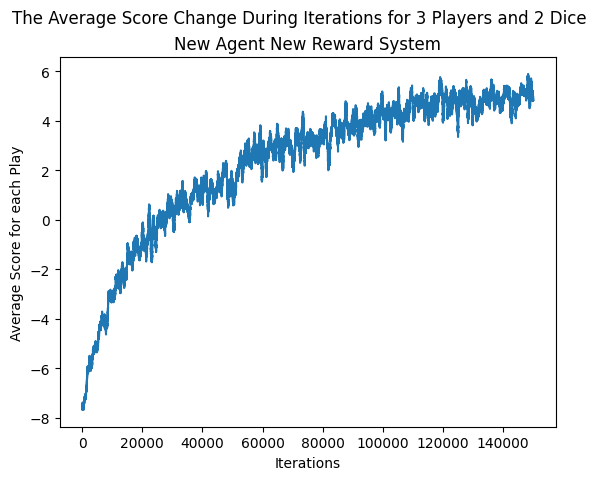

In [14]:
plt.plot((np.arange(len(whole_reward_list)))[100:], whole_reward_list[100:])
plt.xlabel('Iterations')
plt.ylabel('Average Score for each Play')
plt.suptitle('The Average Score Change During Iterations for 3 Players and 2 Dice')
plt.title('New Agent New Reward System')
plt.show()

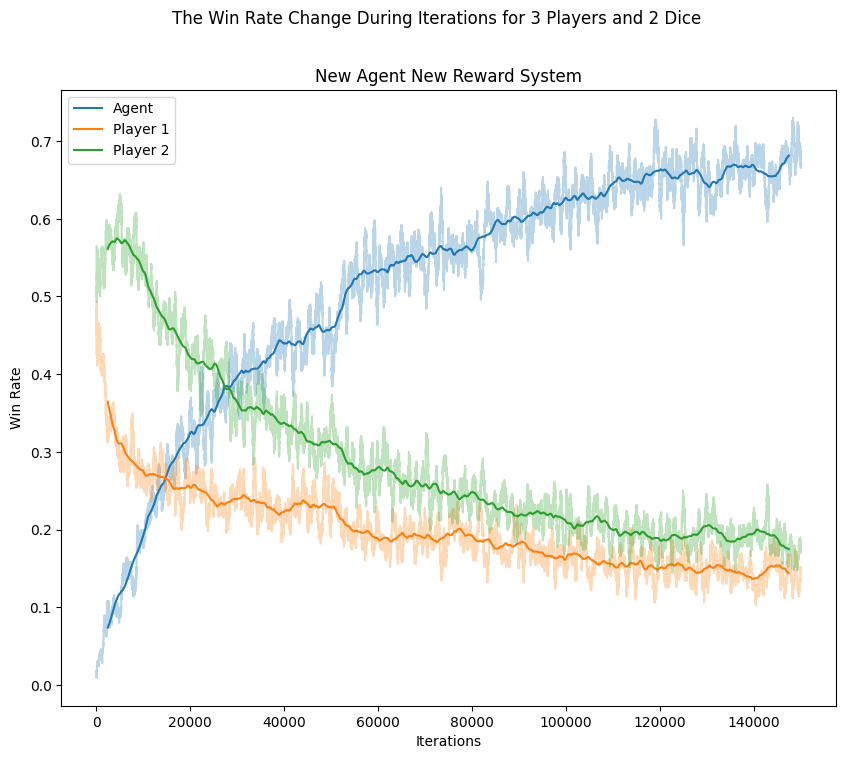

In [15]:
# Function to calculate the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Window size for the moving average
smooth_window_size = 5000  # Adjust this to change the smoothness

plt.figure(figsize=(10, 8))

for i in range(len(whole_ranking_list[0])):
    player_win = [iteration[i] for iteration in whole_win_list]

    # Calculate the moving average (smoothed data)
    smoothed_win = moving_average(player_win[100:150100], smooth_window_size)

    # Plot the original data with transparency
    plt.plot((np.arange(len(player_win)))[100:150100], player_win[100:150100], alpha=0.3, color=f'C{i}')  # 30% transparent

    # Plot the smoothed data
    # Adjust the x-values for the smoothed data
    smoothed_x_values = (np.arange(len(smoothed_win)) + smooth_window_size / 2)
    plt.plot(smoothed_x_values, smoothed_win, label=f"Agent" if i==0 else f"Player {i}", color=f'C{i}')

plt.xlabel('Iterations')
plt.ylabel('Win Rate')
plt.suptitle('The Win Rate Change During Iterations for 3 Players and 2 Dice')
plt.title('New Agent New Reward System')
plt.legend()
plt.show()